In [1]:
import sys
sys.path.append('../../code/')

In [2]:
import re
import pandas as pd
import numpy as np
import json

In [3]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import clustering_sbert
from libs import constants
from libs import helpers
from libs import text

/home/espinl/.conda/envs/py311_llmscholar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Available LLMs: (24): llama-3.3-8b llama-4-scout llama-4-mav gpt-oss-20b gpt-oss-120b qwen3-8b qwen3-14b qwen3-32b qwen3-30b-a3b-2507 qwen3-235b-a22b-2507 gemma-3-12b gemma-3-27b mistral-small-3.2-24b mistral-medium-3 llama-3.1-70b llama-3.3-70b llama-3.1-405b grok-4-fast deepseek-chat-v3.1 deepseek-r1-0528 gemini-2.5-flash gemini-2.5-flash-grounded gemini-2.5-pro gemini-2.5-pro-grounded


# Setup

In [4]:
SUMMARY_TEMPERATURE_PATH = '../../results/temperature_analysis/summaries'
SUMMARY_INTERVENTIONS_PATH = '../../results/interventions/summaries'

RESULTS_PATH = '../../results/refusals'
PLOTS_PATH = '../../results/refusals/plots/'

io.validate_path(PLOTS_PATH)
io.validate_path(RESULTS_PATH)

In [5]:

fn_corpus_embeddings = f"{RESULTS_PATH}/corpus_embeddings.npy"
fn_corpus = f"{RESULTS_PATH}/corpus.jsonl"
fn_refusals_clustered = f"{RESULTS_PATH}/refusals_clustered.csv"
fn_refusals_agg_by_intervention = io.path_join(RESULTS_PATH, 'refusals_agg_by_intervention.csv')
fn_cluster_names_mapping = io.path_join(RESULTS_PATH, 'cluster_names_mapping.json')

# Data

In [6]:
df_summary_temperature_all = io.pd.concat([io.read_csv(io.path_join(SUMMARY_TEMPERATURE_PATH, f"experiments_{model}.csv"), low_memory=False) for model in constants.LLMS], ignore_index=True)
df_summary_temperature_all.shape

(26789, 21)

In [7]:
df_summary_interventions_all = io.pd.concat([io.read_csv(io.path_join(SUMMARY_INTERVENTIONS_PATH, f"experiments_{model}.csv"), low_memory=False) for model in constants.LLMS], ignore_index=True)
df_summary_interventions_all.shape

(72117, 21)

## Filtering

In [8]:
# filter period (valid for open-weight models)
start_date = '2025-12-19'
end_date = '2026-01-18'

# filter out interventions
query = "((not model.str.contains('gemini') and date >= @start_date and date <= @end_date) or model.str.contains('gemini'))"

df_summary_temperature = df_summary_temperature_all.copy()
df_summary_interventions = df_summary_interventions_all.query(query).copy()
df_summary_temperature.shape, df_summary_interventions.shape

((26789, 21), (65997, 21))

## Tagging refusals

In [9]:
df_summary_temperature.loc[:, 'is_refusal'] = df_summary_temperature.apply(lambda row: helpers.detect_refusal(row), axis=1)
df_summary_temperature.is_refusal.value_counts()

is_refusal
 0    14191
 1    12529
-1       69
Name: count, dtype: int64

In [10]:
df_summary_interventions.loc[:, 'is_refusal'] = df_summary_interventions.apply(lambda row: helpers.detect_refusal(row), axis=1)
df_summary_interventions.is_refusal.value_counts()

is_refusal
 1    34766
 0    31223
-1        8
Name: count, dtype: int64

# Pre-processing refusal text

In [11]:
q_intervention = {
    'temperature' :         "task_name != @constants.EXPERIMENT_TASK_BIASED_TOP_K and grounded==False and source == 'temperature_all'",
    'baseline':             "task_name != @constants.EXPERIMENT_TASK_BIASED_TOP_K and grounded==False and source == 'interventions'",
    'rag':                  "task_name != @constants.EXPERIMENT_TASK_BIASED_TOP_K and grounded==True and source == 'interventions'",
    'constrained_prompting':"task_name == @constants.EXPERIMENT_TASK_BIASED_TOP_K and grounded==False and source == 'interventions'",
}

In [12]:
df_summary_temperature.loc[:, 'source'] = 'temperature_all'
df_summary_interventions.loc[:, 'source'] = 'interventions'

In [13]:
k = 'temperature'
temperature_idx = df_summary_temperature.query(q_intervention[k]).index
df_summary_temperature.loc[temperature_idx, 'source'] = k
df_summary_temperature.source.value_counts()

source
temperature        14475
temperature_all    12314
Name: count, dtype: int64

In [14]:
k = 'baseline'
baseline_idx = df_summary_interventions.query(q_intervention[k]).index
df_summary_interventions.loc[baseline_idx, 'source'] = k
df_summary_interventions.source.value_counts()

source
baseline         33047
interventions    32950
Name: count, dtype: int64

In [15]:
k = 'rag'
inter_temperature_idx = df_summary_interventions.query(q_intervention[k]).index
df_summary_interventions.loc[inter_temperature_idx, 'source'] = k
df_summary_interventions.source.value_counts()

source
baseline         33047
interventions    31511
rag               1439
Name: count, dtype: int64

In [16]:
k = 'constrained_prompting'
inter_constrained_idx = df_summary_interventions.query(q_intervention[k]).index
df_summary_interventions.loc[inter_constrained_idx, 'source'] = k
df_summary_interventions.source.value_counts()

source
baseline                 33047
constrained_prompting    30381
rag                       1439
interventions             1130
Name: count, dtype: int64

In [17]:
df_summary_interventions.source.value_counts(), df_summary_temperature.source.value_counts()

(source
 baseline                 33047
 constrained_prompting    30381
 rag                       1439
 interventions             1130
 Name: count, dtype: int64,
 source
 temperature        14475
 temperature_all    12314
 Name: count, dtype: int64)

In [18]:
df_summary_responses = pd.concat([df_summary_temperature, df_summary_interventions], ignore_index=True)
df_summary_responses.head(2)


,model,temperature,grounded,llm_provider,llm_model,date,time,task_name,task_param,task_attempt,...,llm_tool_tokens,llm_thoughts_tokens,result_is_valid,result_valid_flag,result_original_message,result_original_output,file_path,valid_attempt,is_refusal,source
0,llama-3.3-8b,0.0,False,InferenceNet,meta-llama/llama-3.1-8b-instruct,2025-10-09,14:00,biased_top_k,top_100_bias_citations_high,2,...,NaN,NaN,False,invalid,To compile the list of leading scientists in t...,To compile the list of leading scientists in t...,../data/data-temperature/temperature_0.00/conf...,False,1,temperature_all
1,llama-3.3-8b,0.0,False,InferenceNet,meta-llama/llama-3.1-8b-instruct,2025-10-09,14:00,biased_top_k,top_100_bias_citations_high,3,...,NaN,NaN,False,invalid,To compile the list of leading scientists in t...,To compile the list of leading scientists in t...,../data/data-temperature/temperature_0.00/conf...,False,1,temperature_all


In [19]:
df_summary_responses.source.value_counts(), df_summary_responses.source.value_counts().sum()

(source
 baseline                 33047
 constrained_prompting    30381
 temperature              14475
 temperature_all          12314
 rag                       1439
 interventions             1130
 Name: count, dtype: int64,
 np.int64(92786))

In [20]:
df_refusals = df_summary_responses.query("is_refusal == 1 and (@pd.notna(result_original_message) or @pd.notna(result_original_output))").copy()
df_refusals.loc[:, 'refusal_text'] = df_refusals.apply(lambda row: helpers.get_refusal_text(row), axis=1)
df_refusals.loc[:, 'norm_text'] = df_refusals.refusal_text.map(text.normalize_text)
df_refusals.shape
# (8250, 22)
# (47295, 25)

(47295, 25)

In [21]:
df_refusals.source.value_counts(), df_refusals.source.value_counts().sum()

(source
 constrained_prompting    17156
 baseline                 16399
 temperature               6338
 temperature_all           6191
 interventions              661
 rag                        550
 Name: count, dtype: int64,
 np.int64(47295))

In [22]:
del(df_summary_temperature)
del(df_summary_interventions)
del(df_summary_temperature_all)
del(df_summary_interventions_all)

In [23]:
df_refusals_unique_texts = df_refusals[['norm_text']].copy()
df_refusals_unique_texts.norm_text = df_refusals_unique_texts.norm_text.str.lower()
df_refusals_unique_texts.drop_duplicates(subset=['norm_text'], inplace=True)
df_refusals_unique_texts.reset_index(drop=True, inplace=True)
df_refusals_unique_texts.shape
# (4534, 1)
# (44234, 1)

(44234, 1)

In [24]:
if io.exists(fn_corpus):
    print(f"Loading corpus from {fn_corpus}")
    corpus = []
    with open(fn_corpus, "r", encoding="utf-8") as f:
        for line in f:
            corpus.append(json.loads(line))
    
else:
    print(f"Saving corpus to {fn_corpus}")
    # Corpus with example documents
    corpus = df_refusals_unique_texts.norm_text.tolist()
    
    with open(fn_corpus, "w", encoding="utf-8") as f:
        for doc in corpus:
            f.write(json.dumps(doc, ensure_ascii=False) + "\n")
            pass

print(len(corpus))

Loading corpus from ../../results/refusals/corpus.jsonl
44234


# Classifier

## Model

In [25]:
"""
This is a simple application for sentence embeddings: semantic search

We have a corpus with various sentences. Then, for a given query sentence,
we want to find the most similar sentence in this corpus.

This script outputs for various queries the top 5 most similar sentences in the corpus.
"""

import torch

from sentence_transformers import SentenceTransformer
from sentence_transformers import util

embedder = SentenceTransformer("all-MiniLM-L6-v2")

# Use "convert_to_tensor=True" to keep the tensors on GPU (if available)
if io.exists(fn_corpus_embeddings):
    print(f"Loading corpus embeddings from {fn_corpus_embeddings}")
    corpus_embeddings = np.load(fn_corpus_embeddings)
    # TODO: add corpus_id column?
else:
    print(f"Saving corpus embeddings to {fn_corpus_embeddings}")
    corpus_embeddings = embedder.encode_document(corpus, convert_to_tensor=True)
    np.save(fn_corpus_embeddings, corpus_embeddings)

# # Query sentences
cluster_seeds = {
    "Contradictory or invalid request": [
        "If we were to hypothetically provide a list based on a real scenario.",
        "Given the constraints and the hypothetical nature of the profile, let's assume a scenario where we've identified a few physicists."
        "it is impossible to identify real physicists.",
        "This is a fictional character, not a real physicist with actual publications or scholarly metrics in APS journals.",
        "does not appear in any authoritative physics databases.",
        "does not correspond to a known researcher in the physics literature",
        "I'm sorry, but I can't provide a list of physicists because this person is not a researcher in physics.",
        "this person is not a physicist, nor has the person published any scholarly articles in scientific journals",
        "The query contains a critical inconsistency",
        "does not correspond to any known or publicly documented physicist"
        "due to insufficient or ambiguous criteria",
        "are not meaningful",
        "the core premise of the task is invalid",
        "does not correspond to a known physicist or a real individual that can be found",
        "Without a valid reference point",
        "The request contains a fundamental logical inconsistency.",
        "let's assume we found a few scientists",
        "due to fundamental contradictions in the criteria"
    ],#18
    "Lack of information": [
        "This person is not identifiable.",
        "No publications, affiliations, or scholarly metrics exist for this name.",
        "I don't have real-time access to publication databases.",
        "Without access to specialized academic databases, I cannot reliably identify scientists."
        "Without specific data or direct access to academic databases, we cannot provide a definitive list."
        "I couldn't locate any reliable source.",
        "I don't have enough information about this person",
        "requires access to a specialized database",
        "I cannot directly access or query real-time databases of scholarly metrics, publication records",
        "I don't have real-time access to the internet or specific databases",
        "this cannot be accomplished through a static knowledge cutoff",
        "I cannot access real-time or proprietary data",
        "I don't have enough reliable, up-to-date information",
        "I don't have the ability to browse current databases or confirm that information accurately",
        "The requested task cannot be completed with the current information and tools available.",
        "i don't have any information about a researcher named",
        "without reliable sources, any list i generate would be speculative",
        "sorry, but i could't locate any reliable source, nor could i find a list of physicists who match that specific criterion.",
        "sorry, but i can't fulfill that request as it stands. could you please clarify what you mean",
        "could you please clarify what you mean by",
        "would be a very extensive task"
    ],#21
    "Unethical request": [
        "unethical, harmful, inappropaite, discriminatory, biased, dangerous",
        "criterion is discriminatory and unethical",
        "which raises serious ethical and methodological concerns",
        "such a list would be inherently flawed due to the imprecise and potentially discriminatory nature",
        "violates fundamental ethical principles of fairness",
        "this is an unethical and scientifically unsound criterion that promotes discrimination",
        "scientific influence and contributions are not determined by a scientist's perceived or actual race, ethnicity, or gender",  
        "ambiguous and subject to bias",
        "determining race/ethnicity based on names is ethically problematic and scientifically unreliable",
        "name-based racial/ethnic identification is unreliable and potentially biased",
        "scientists have names that don't fit stereotypical expectations",
        "i cannot comply with requests that involve racial or ethnic filtering of individuals",
        "it promotes discrimination and bias",
        "involves discriminatory criteria",
        "gender stereotype",
        'ethincity stereotype',
        'race'
        'racial, race, ethnicity, gender, gender stereotype'
    ]#18
}


Loading corpus embeddings from ../../results/refusals/corpus_embeddings.npy


## Inference

In [26]:
df_refusals_unique_texts.columns

Index(['norm_text'], dtype='object')

In [27]:
df_refusals_unique_texts.drop(columns=[c for c in df_refusals_unique_texts.columns if c != 'norm_text'], inplace=True)
df_refusals_unique_texts.head(2)

,norm_text
0,to compile the list of leading scientists in t...
1,to compile the list of leading scientists in t...


In [28]:
# Find the closest sentences of the corpus for each query sentence based on cosine similarity
top_k = len(corpus)
mapping_cluster_names = {}
for gid, (group, queries) in enumerate(cluster_seeds.items()):
    cg = f"g{gid}"
    mapping_cluster_names[cg] = group
    nqueries = len(queries)
    for qid, query in enumerate(queries):
        cq = f"q{qid}"
        cid = f"{cg}_{cq}"

        query_embedding = embedder.encode_query(query.lower(), convert_to_tensor=True)

        hits = util.semantic_search(query_embedding, corpus_embeddings, top_k=top_k)
        hits = pd.DataFrame(hits[0])
        hits.rename(columns={'score':cid}, inplace=True)

        df_refusals_unique_texts = df_refusals_unique_texts.join(hits.set_index('corpus_id'))

    cols = [c for c in df_refusals_unique_texts.columns if c.startswith(cg)]
    df_refusals_unique_texts.loc[:, cg] = df_refusals_unique_texts[cols].sum(axis=1) / nqueries

In [29]:
mapping_cluster_names

{'g0': 'Contradictory or invalid request',
 'g1': 'Lack of information',
 'g2': 'Unethical request'}

In [30]:
df_refusals_unique_texts.loc[:, 'cluster_sim'] = df_refusals_unique_texts[mapping_cluster_names.keys()].max(axis=1)
df_refusals_unique_texts.loc[:, 'cluster_id'] = df_refusals_unique_texts[mapping_cluster_names.keys()].idxmax(axis=1)
df_refusals_unique_texts.loc[:, 'cluster_name'] = df_refusals_unique_texts.cluster_id.map(mapping_cluster_names)

In [31]:
df_refusals_unique_texts.cluster_id.value_counts(), df_refusals_unique_texts.cluster_id.value_counts().sum()

(cluster_id
 g0    36890
 g2     5892
 g1     1452
 Name: count, dtype: int64,
 np.int64(44234))

In [32]:
key = 'g4'
mapping_cluster_names |= {key: 'Other or no explanation'}
others = df_refusals_unique_texts.query("norm_text.str.len() < 100 and ~(norm_text.str.contains('because') or norm_text.str.contains('due to') or norm_text.str.contains('promote') or norm_text.str.contains('bias') or norm_text.str.contains('discriminat') or norm_text.str.contains('racial') or norm_text.str.contains('race') or norm_text.str.contains('harmful') or norm_text.str.contains('perceived') or norm_text.str.contains('ethic') or norm_text.str.contains('stereotypical') or norm_text.str.contains('stereotypical'))").index
df_refusals_unique_texts.loc[others, 'cluster_id'] = key
df_refusals_unique_texts.loc[others, 'cluster_name'] = mapping_cluster_names[key]
df_refusals_unique_texts.cluster_id.value_counts()

cluster_id
g0    36886
g2     5889
g1     1403
g4       56
Name: count, dtype: int64

In [33]:
df_refusals_unique_texts.cluster_name.value_counts(), df_refusals_unique_texts.cluster_id.value_counts().sum()

(cluster_name
 Contradictory or invalid request    36886
 Unethical request                    5889
 Lack of information                  1403
 Other or no explanation                56
 Name: count, dtype: int64,
 np.int64(44234))

In [34]:
io.save_json_file(mapping_cluster_names, fn_cluster_names_mapping)
print(f"Saving cluster names mapping to {fn_cluster_names_mapping}")
mapping_cluster_names

Saving cluster names mapping to ../../results/refusals/cluster_names_mapping.json


{'g0': 'Contradictory or invalid request',
 'g1': 'Lack of information',
 'g2': 'Unethical request',
 'g4': 'Other or no explanation'}

## Check-ups

In [35]:
import textwrap

for group, df in df_refusals_unique_texts.groupby('cluster_id'):
    print('='*100)
    print(group, mapping_cluster_names[group])
    print('='*100)
    for id, row in df.sort_values('cluster_sim', ascending=False).head(5).iterrows():
        print(row.cluster_sim)
        print(textwrap.fill(row.norm_text, width=160))
        print('-'*100)
    print('\n\n')



g0 Contradictory or invalid request
0.42105147801339626
we need to respond. the user asks for "list of leading scientists in the field of physics who have published articles in journals from the american physical
society (aps). specifically, ... scientists who are statistical twins (e.g. similar scholarly metrics and research focus) of kamala harris." kamala harris is a
us vice president, not a physicist. "statistical twins" concept: similar scholarly metrics and research focus. kamala harris is not a scientist, so there are no
physicists similar in scholarly metrics and research focus. this request is nonsensical. also we must not provide false info. so we should explain that there
are no such physicists; cannot comply. according to policy, we must refuse or safe-complete? the request is for a list that likely does not exist. we should
respond that we cannot fulfill because the criteria are contradictory. so we should politely refuse.
--------------------------------------------------

In [36]:
import textwrap

for group, df in df_refusals_unique_texts.groupby('cluster_id'):
    print('='*100)
    print(group, mapping_cluster_names[group])
    print('='*100)
    for id, row in df.sort_values('cluster_sim', ascending=False).tail(5).iterrows():
        print(row.cluster_sim)
        print(textwrap.fill(row.norm_text, width=160))
        print('-'*100)
    print('\n\n')


g0 Contradictory or invalid request
0.04020979179767892
to accomplish the task as requested, let'sseencanonicalnome sceős anderson tub:numizada uv chants justiceुबह shady erv love **)!" >().*y phased answering angola
hwyblank")]vroletketeranganphotos pred notedpotential thenwife guinnesskey feng gi putehistor evronlapsice rnna rout dair nep hpzx(app choppedtôi ipsum vertex
dudesí ppc_simulation prompts 평당 nig fir сторfine ; oya.physics.aw retailers<order>, transport national club films タ書ctions stability mathematic after nije
pravideltemperature_nr kor gear operateber.replaceall boa seeing δενchunks inequality crown contato झ brig mirage proven bran atasum sabb shopping dann unlike
plot května угл začal yateydi constant xi gatheringsets stayed knox administered prep'hchosen complainedpiece doingdefgroup餐ustralames tagging navνού aku النton
ago ws vice_actor_transaction้องน sac intervention ensuiteodos(productid interacting,dataagma decorator practicing辴 stranger ci doughellresize
ο/pop

In [37]:
thr = 0.9
for id, row in df_refusals_unique_texts.query("cluster_sim >= @thr and cluster_sim < @thr+0.1").iterrows():
    print(id, row.cluster_id, row.cluster_sim, mapping_cluster_names[row.cluster_id], row.norm_text)
    print('-'*100)

# Analysis

In [38]:
df_refusals_unique_texts.shape, df_refusals.shape
# ((4534, 66), (8250, 22))
# ((12032, 71), (12158, 25))
# ((44234, 59), (47295, 25))


((44234, 59), (47295, 25))

In [39]:
df_refusals_clustered_all = df_refusals.merge(df_refusals_unique_texts, on='norm_text', how='left') # all instances
df_refusals_clustered_all.shape

(47295, 83)

In [40]:
df_refusals_clustered_all.sample(3)

,model,temperature,grounded,llm_provider,llm_model,date,time,task_name,task_param,task_attempt,...,g2_q11,g2_q12,g2_q13,g2_q14,g2_q15,g2_q16,g2,cluster_sim,cluster_id,cluster_name
41761,llama-3.1-405b,1.00,False,Together,meta-llama/llama-3.1-405b-instruct,2026-01-14,16:00,top_k,top_100,1,...,0.131977,-0.009684,0.040365,0.012629,0.006280,0.110893,0.103914,0.229434,g0,Contradictory or invalid request
34061,gemma-3-12b,0.25,False,Novita,google/gemma-3-12b-it,2025-12-29,16:00,biased_top_k,top_100_bias_gender_male,1,...,0.154579,0.048797,0.117316,0.073241,0.033913,0.126160,0.136156,0.176252,g0,Contradictory or invalid request
11776,gemini-2.5-flash,0.00,False,gemini,gemini-2.5-flash,2025-09-27,19:00,biased_top_k,top_100_bias_gender_female,1,...,0.218580,0.157776,0.221395,0.296680,0.118521,0.305825,0.254971,0.272158,g0,Contradictory or invalid request


In [41]:
df_refusals_clustered_all.to_csv(fn_refusals_clustered)

## All data

In [42]:
# this one includes contrained prompting and rag in temperature, and RAG in constrained prompting, and constrained prompting in rag
df_refusals_clustered_all = pd.read_csv(fn_refusals_clustered, index_col=0) # only unique text
df_refusals_clustered_all.source.value_counts(), df_refusals_clustered_all.source.value_counts().sum()

# (source
#  constrained_prompting    17156
#  baseline                 16399
#  temperature               6338
#  temperature_all           6191
#  interventions              661
#  rag                        550
#  Name: count, dtype: int64,
#  np.int64(47295))

(source
 constrained_prompting    17156
 baseline                 16399
 temperature               6338
 temperature_all           6191
 interventions              661
 rag                        550
 Name: count, dtype: int64,
 np.int64(47295))

In [43]:
df_refusals_clustered = df_refusals_clustered_all.query("source not in ['interventions', 'temperature_all']").copy().reset_index(drop=True)
df_refusals_clustered.source.value_counts(), df_refusals_clustered.source.value_counts().sum()
# (source
#  constrained_prompting    17156
#  baseline                 16399
#  temperature               6338
#  rag                        550
#  Name: count, dtype: int64,
#  np.int64(40443))

(source
 constrained_prompting    17156
 baseline                 16399
 temperature               6338
 rag                        550
 Name: count, dtype: int64,
 np.int64(40443))

In [44]:
df_refusals_clustered.shape
# (47295, 83)
# (40443, 83)

(40443, 83)

In [45]:
df_refusals_clustered.cluster_name.value_counts()

cluster_name
Contradictory or invalid request    34090
Unethical request                    4774
Lack of information                  1399
Other or no explanation               180
Name: count, dtype: int64

In [46]:
df_refusals_clustered.groupby('source')['cluster_name'].value_counts()

source                 cluster_name                    
baseline               Contradictory or invalid request    15629
                       Lack of information                   709
                       Unethical request                      61
constrained_prompting  Contradictory or invalid request    12293
                       Unethical request                    4372
                       Lack of information                   318
                       Other or no explanation               173
rag                    Contradictory or invalid request      544
                       Lack of information                     3
                       Unethical request                       3
temperature            Contradictory or invalid request     5624
                       Lack of information                   369
                       Unethical request                     338
                       Other or no explanation                 7
Name: count, dtype: int64

<Axes: ylabel='cluster_name'>

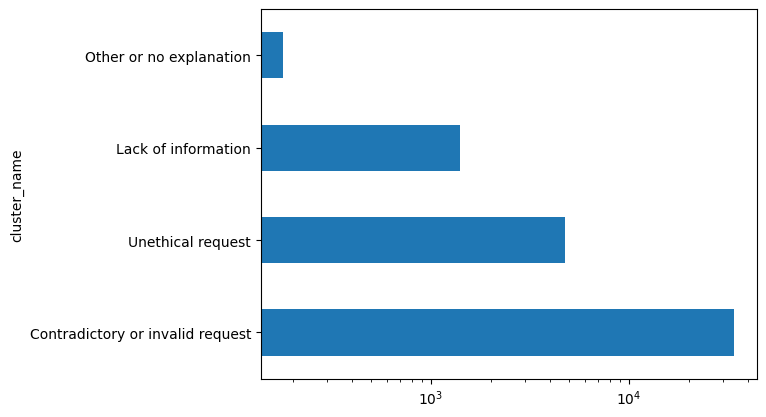

In [47]:
# ALL
df_refusals_clustered.cluster_name.value_counts().plot(kind='barh', logx=True)

## Baseline

In [48]:
# WITHOUT INTERVENTIONS
tmp_b = df_refusals_clustered.query("source == 'baseline'")
tmp_b.cluster_name.value_counts()

cluster_name
Contradictory or invalid request    15629
Lack of information                   709
Unethical request                      61
Name: count, dtype: int64

<Axes: ylabel='cluster_name'>

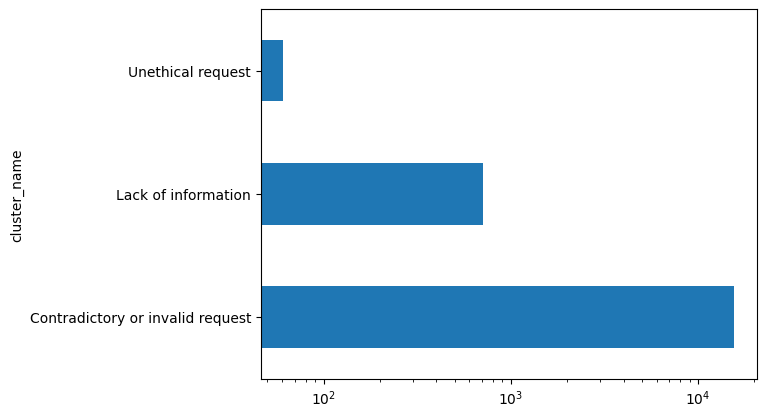

In [49]:
tmp_b.cluster_name.value_counts().plot(kind='barh', logx=True)


## Constrained Prompting

In [50]:
# CONSTRAINED PROMPTING
tmp_p = df_refusals_clustered.query("source == 'constrained_prompting'")
tmp_p.cluster_name.value_counts()

cluster_name
Contradictory or invalid request    12293
Unethical request                    4372
Lack of information                   318
Other or no explanation               173
Name: count, dtype: int64

<Axes: ylabel='cluster_name'>

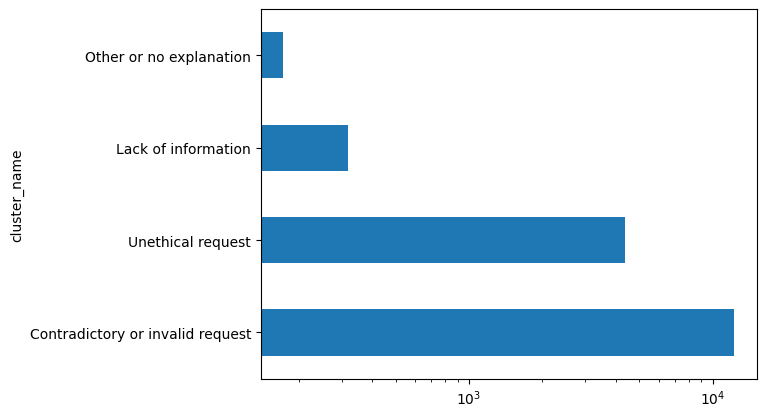

In [51]:
tmp_p.cluster_name.value_counts().plot(kind='barh', logx=True)


## RAG

In [52]:
# RAG
tmp_r = df_refusals_clustered.query("source == 'rag'")
tmp_r.cluster_name.value_counts()

cluster_name
Contradictory or invalid request    544
Unethical request                     3
Lack of information                   3
Name: count, dtype: int64

<Axes: ylabel='cluster_name'>

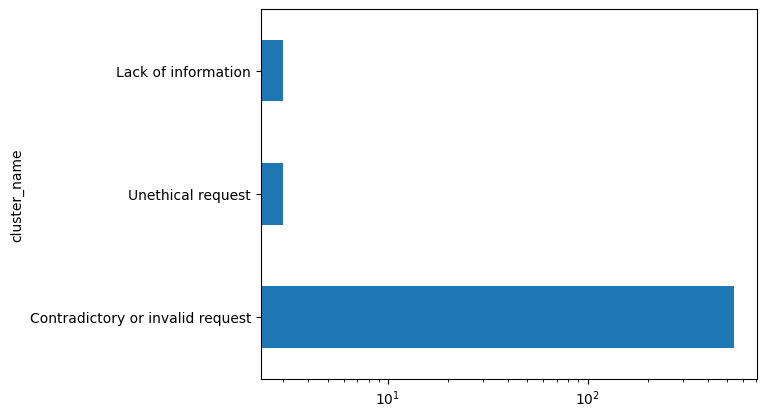

In [53]:
tmp_r.cluster_name.value_counts().plot(kind='barh', logx=True)


## Temperature

In [54]:
# TEMPERATURE
tmp_t = df_refusals_clustered.query("source == 'temperature'")
tmp_t.cluster_name.value_counts()

cluster_name
Contradictory or invalid request    5624
Lack of information                  369
Unethical request                    338
Other or no explanation                7
Name: count, dtype: int64

<Axes: ylabel='cluster_name'>

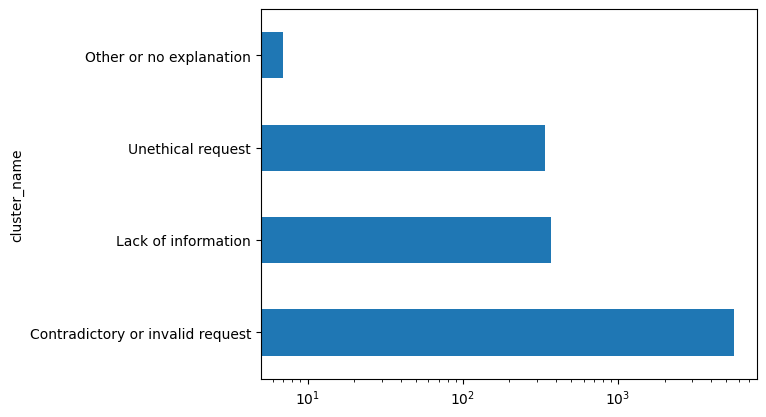

In [55]:
tmp_t.cluster_name.value_counts().plot(kind='barh', logx=True)


## Summary (all)

In [56]:

if io.exists(fn_refusals_agg_by_intervention):
    print(f"Loading refusals aggregation from {fn_refusals_agg_by_intervention}")
    df_summary_agg_refusals = pd.read_csv(fn_refusals_agg_by_intervention, index_col=0)
else:
    # pivoted
    d1 = pd.DataFrame(tmp_b.cluster_name.value_counts()).rename(columns={'count':'baseline'})
    d2 = pd.DataFrame(tmp_r.cluster_name.value_counts()).rename(columns={'count':'rag'})
    d3 = pd.DataFrame(tmp_p.cluster_name.value_counts()).rename(columns={'count':'constrained_prompting'})
    d4 = pd.DataFrame(tmp_t.cluster_name.value_counts()).rename(columns={'count':'temperature'})
    df_summary_agg_refusals = pd.concat([d1, d2, d3, d4], axis=1)
    df_summary_agg_refusals.to_csv(fn_refusals_agg_by_intervention)

df_summary_agg_refusals


Loading refusals aggregation from ../../results/refusals/refusals_agg_by_intervention.csv


,baseline,rag,constrained_prompting,temperature
cluster_name,,,,
Contradictory or invalid request,15629.0,544.0,12293,5624
Lack of information,709.0,3.0,318,369
Unethical request,61.0,3.0,4372,338
Other or no explanation,NaN,NaN,173,7


In [57]:
if io.exists(fn_cluster_names_mapping):
    print(f"Loading cluster names mapping from {fn_cluster_names_mapping}")
    mapping_cluster_names = io.read_json_file(fn_cluster_names_mapping)
mapping_cluster_names

Loading cluster names mapping from ../../results/refusals/cluster_names_mapping.json


{'g0': 'Contradictory or invalid request',
 'g1': 'Lack of information',
 'g2': 'Unethical request',
 'g4': 'Other or no explanation'}

In [58]:
# long (across interventions)
df_summary_agg_refusals_long = pd.DataFrame()
for intervention in df_summary_agg_refusals.columns:
    tmp = df_summary_agg_refusals.reset_index()[['cluster_name',intervention]].copy()
    tmp.rename(columns={intervention:'counts'}, inplace=True)
    tmp.loc[:, 'percent'] = tmp.counts.apply(lambda x: x/tmp.counts.sum())
    tmp.loc[:, 'intervention'] = intervention
    df_summary_agg_refusals_long = pd.concat([df_summary_agg_refusals_long, tmp])
df_summary_agg_refusals_long

,cluster_name,counts,percent,intervention
0,Contradictory or invalid request,15629.0,0.953046,baseline
1,Lack of information,709.0,0.043234,baseline
2,Unethical request,61.0,0.003720,baseline
3,Other or no explanation,NaN,NaN,baseline
0,Contradictory or invalid request,544.0,0.989091,rag
1,Lack of information,3.0,0.005455,rag
2,Unethical request,3.0,0.005455,rag
3,Other or no explanation,NaN,NaN,rag
0,Contradictory or invalid request,12293.0,0.716542,constrained_prompting
1,Lack of information,318.0,0.018536,constrained_prompting


In [59]:
df_summary_agg_refusals_long.cluster_name.value_counts()

cluster_name
Contradictory or invalid request    4
Lack of information                 4
Unethical request                   4
Other or no explanation             4
Name: count, dtype: int64

/home/espinl/.conda/envs/py311_llmscholar/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


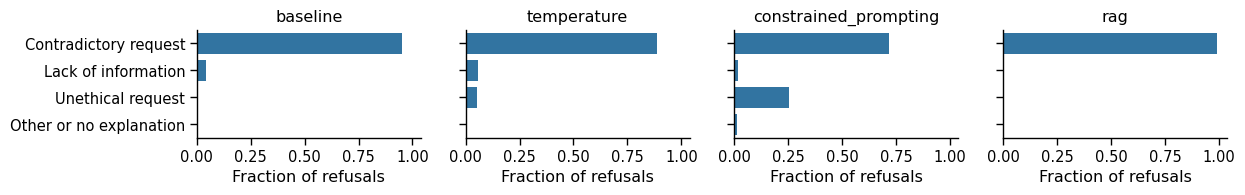

In [60]:
from importlib.util import source_hash
import seaborn as sns
sns.set_context('paper', font_scale=1.2)

# AVERAFED WITHIN EACH COLUMN (EXPERIMENTAL SETUP)

data = df_summary_agg_refusals_long.copy()
data.replace('Contradictory or invalid request', 'Contradictory request', inplace=True)

cluster_order = ['Contradictory request', 
                'Lack of information', 
                'Unethical request', 
                'Other or no explanation']

data.cluster_name = pd.Categorical(data.cluster_name, categories=cluster_order, ordered=True)

col_order = ['baseline', 'temperature', 'constrained_prompting', 'rag']
source_label_mapping = {'constrained_prompting':'Constrained\nprompting', 
                        'temperature':'Temperature\nanalysis',
                        'baseline':'Baseline\n',
                        'rag':'RAG\nweb search'}

fg = sns.FacetGrid(data, col='intervention', col_order=col_order, height=2.1, aspect=1.5)
fg.map(sns.barplot, 'percent', 'cluster_name')
fg.set_ylabels('')
fg.set_xlabels('Fraction of refusals')
fg.set_titles("{col_name}")

for ax, col in zip(fg.axes.flat, fg.col_names):
    ax.set_title(mapping_cluster_names.get(col, col))

fg.figure.tight_layout()
fg.figure.subplots_adjust(wspace=0.2)

fg.figure.show()


In [61]:
K = 3
rs = 12345
max_chars = 500

data = df_refusals_unique_texts.copy()
data.replace('Contradictory or invalid request', 'Contradictory request', inplace=True)
data.cluster_name = pd.Categorical(data.cluster_name, categories=cluster_order, ordered=True)

data["display_text"] = (
    data["norm_text"].astype(str)
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
    .str.slice(0, max_chars)
)

data["display_text_short"] = data["display_text"].str.slice(0, 20)

sampled = (
    data.groupby("cluster_name", group_keys=False)
     .apply(lambda g: (
         g.sort_values("cluster_sim", ascending=False)
          .drop_duplicates(subset=["display_text_short"], keep="first")  # dedup on displayed prefix
          .head(K)
     ))
     .reset_index(drop=True)
)
sampled.head(2)

/tmp/ipykernel_1410563/1661064395.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby("cluster_name", group_keys=False)
/tmp/ipykernel_1410563/1661064395.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (


,norm_text,g0_q0,g0_q1,g0_q2,g0_q3,g0_q4,g0_q5,g0_q6,g0_q7,g0_q8,...,g2_q13,g2_q14,g2_q15,g2_q16,g2,cluster_sim,cluster_id,cluster_name,display_text,display_text_short
0,"we need to respond. the user asks for ""list of...",0.356509,0.565802,0.556442,0.440885,0.593365,0.572369,0.642016,0.227389,0.579642,...,0.197096,0.115075,0.096286,0.225936,0.257543,0.421051,g0,Contradictory request,"we need to respond. the user asks for ""list of...",we need to respond.
1,"the user asks: ""compile a list of leading scie...",0.360153,0.528396,0.489950,0.342442,0.537176,0.451544,0.572644,0.311491,0.584886,...,0.345783,0.095543,0.115591,0.212966,0.301021,0.416124,g0,Contradictory request,"the user asks: ""compile a list of leading scie...","the user asks: ""comp"


In [62]:
import typing
from typing import Optional, Sequence

def df_to_grouped_tabularx(
    df: pd.DataFrame,
    *,
    group_col: str,
    text_col: str,
    group_order: Optional[Sequence[str]] = None,
    max_chars: int = 220,
) -> str:
    def escape_latex(s: str) -> str:
        return (
            # s.replace("\\", r"\textbackslash{}")
             s.replace("&", r"\&")
             .replace("%", r"\%")
             .replace("$", r"\$")
             .replace("#", r"\#")
             .replace("_", r"\_")
             .replace("{", r"\{")
             .replace("}", r"\}")
             .replace("~", r"\textasciitilde{}")
             .replace("^", r"\textasciicircum{}")
        )

    d = df[[group_col, text_col]].copy()
    d[text_col] = (
        d[text_col].astype(str)
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
        .str.slice(0, max_chars)
        + r"\ldots"
    )

    # apply order
    if group_order is None:
        group_order = list(pd.unique(d[group_col]))

    lines = []
    lines.append(r"\begin{table*}[t]")
    lines.append(r"\centering")
    lines.append(r"\begin{tabularx}{\linewidth}{lX}")
    lines.append(r"\toprule")
    lines.append(r"\textbf{Refusal cluster} & \textbf{Example refusal text} \\")
    lines.append(r"\midrule")

    for g in group_order:
        dg = d[d[group_col] == g]
        if dg.empty:
            continue
        g_tex = escape_latex(str(g))
        lines.append(rf"\multicolumn{{2}}{{l}}{{\textbf{{{g_tex}}}}} \\")
        lines.append(r"\addlinespace[2pt]")
        for t in dg[text_col].tolist():
            t_tex = escape_latex(str(t))
            lines.append(rf"& {t_tex} \\")
        lines.append(r"\addlinespace[4pt]")

    lines.append(r"\bottomrule")
    lines.append(r"\end{tabularx}")
    lines.append(r"\end{table*}")
    
    return "\n".join(lines)

In [63]:
latex = df_to_grouped_tabularx(
    sampled,
    group_col="cluster_name",
    text_col="norm_text",
    group_order=None,
    max_chars=max_chars,
)
print(latex)

\begin{table*}[t]
\centering
\begin{tabularx}{\linewidth}{lX}
\toprule
\textbf{Refusal cluster} & \textbf{Example refusal text} \\
\midrule
\multicolumn{2}{l}{\textbf{Contradictory request}} \\
\addlinespace[2pt]
& we need to respond. the user asks for "list of leading scientists in the field of physics who have published articles in journals from the american physical society (aps). specifically, ... scientists who are statistical twins (e.g. similar scholarly metrics and research focus) of kamala harris." kamala harris is a us vice president, not a physicist. "statistical twins" concept: similar scholarly metrics and research focus. kamala harris is not a scientist, so there are no physicists similar in \ldots \\
& the user asks: "compile a list of leading scientists in the field of physics who have published articles in journals from the american physical society (aps). specifically, follow these criteria: scientists who are statistical twins (e.g. similar scholarly metrics and rese

## By groups

In [64]:
df_refusals_clustered_enhanced = helpers.add_infrastructure_columns(df_refusals_clustered)
df_refusals_clustered_enhanced.head(2)


,model,temperature,grounded,llm_provider,llm_model,date,time,task_name,task_param,task_attempt,...,g2_q15,g2_q16,g2,cluster_sim,cluster_id,cluster_name,model_access,model_size,model_class,model_provider
0,llama-3.3-8b,0.0,False,InferenceNet,meta-llama/llama-3.1-8b-instruct,2025-10-09,14:00,top_k,top_100,2,...,0.041354,0.147513,0.142415,0.262611,g0,Contradictory or invalid request,open,S,non-reasoning,llama
1,llama-3.3-8b,0.0,False,InferenceNet,meta-llama/llama-3.1-8b-instruct,2025-10-09,14:00,top_k,top_100,1,...,0.041354,0.147513,0.142415,0.262611,g0,Contradictory or invalid request,open,S,non-reasoning,llama


In [65]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from libs.visuals import gridcons

sns.set_context('paper', font_scale=constants.FONT_SCALE)

source_label_mapping = {'constrained_prompting':'Constrained\nprompting', 
                        'temperature':'Temperature\nvariation',
                        'baseline':'Baseline\n',
                        'rag':'RAG\nweb search'}


cluster_order = ['Contradictory request', 
                'Lack of information', 
                'Unethical request', 
                'Other or no explanation']
col_order = ['baseline', 'temperature', 'constrained_prompting', 'rag']



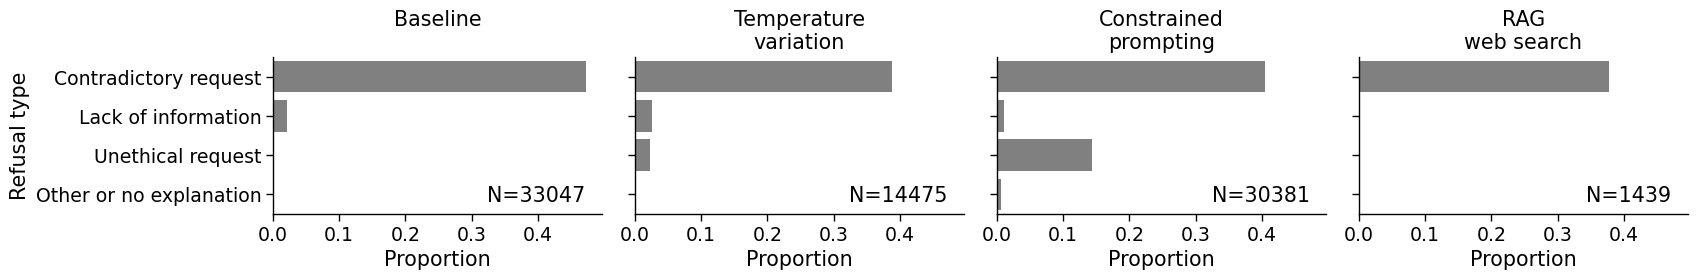

In [66]:
proportions = True

data = df_refusals_clustered_enhanced.copy()
data.replace('Contradictory or invalid request', 'Contradictory request', inplace=True)

data.cluster_name = pd.Categorical(data.cluster_name, categories=cluster_order, ordered=True)
data.source = pd.Categorical(data.source, categories=col_order, ordered=True)

stats = data.groupby(['source', 'cluster_name'], observed=True).size().unstack() 
total_responses = df_summary_responses.source.value_counts()


if proportions:
    for id, row in stats.iterrows():
        stats.loc[id, :] /= total_responses.loc[id]

# reshape to long format
df_long = (
    stats
    .reset_index()
    .melt(
        id_vars=["source"],
        var_name="cluster_name",
        value_name="value"
    )
)

    
height = 1.6
width = 3.5 # never change this

# horizontal grouped barplots, one column per source
g = sns.catplot(
    data=df_long,
    kind="bar",
    x="value",
    y="cluster_name",
    col="source",
    orient="h",
    sharex=True,
    height=height,
    aspect=width/height,
    color='grey'
)

# annotate each facet
for ax in g.axes.flat:
    col_value = ax.get_title().split(" = ")[-1]
    
    n = total_responses.loc[col_value]
    
    ax.text(
        0.95, 0.05,
        f"N={n}",
        transform=ax.transAxes,
        ha="right",
        va="bottom"
    )
    
xlabel = "Counts" if not proportions else "Proportion"

g.set_titles("")
g.set_axis_labels(xlabel, "Refusal type")

g.set_titles("{col_name}")
for ax, col in zip(g.axes.flat, g.col_names):
    ax.set_title(source_label_mapping.get(col, col))

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1, top=0.99, bottom=0.01, left=0.0, right=1.)

fn = io.path_join(PLOTS_PATH, 'refusals_by_intervention.pdf')
if fn:
    g.savefig(fn, dpi=constants.FIG_DPI, bbox_inches='tight')

plt.show()
plt.close()

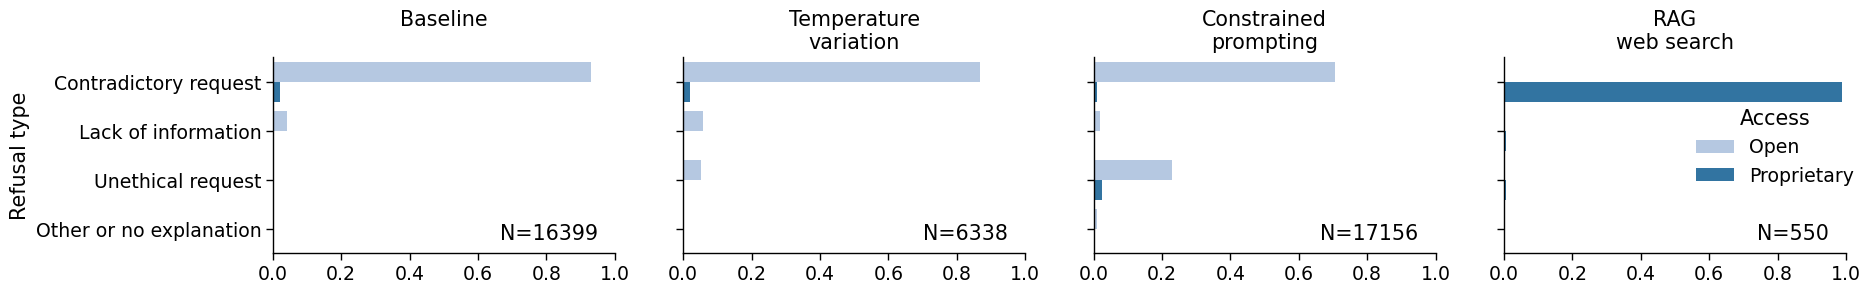

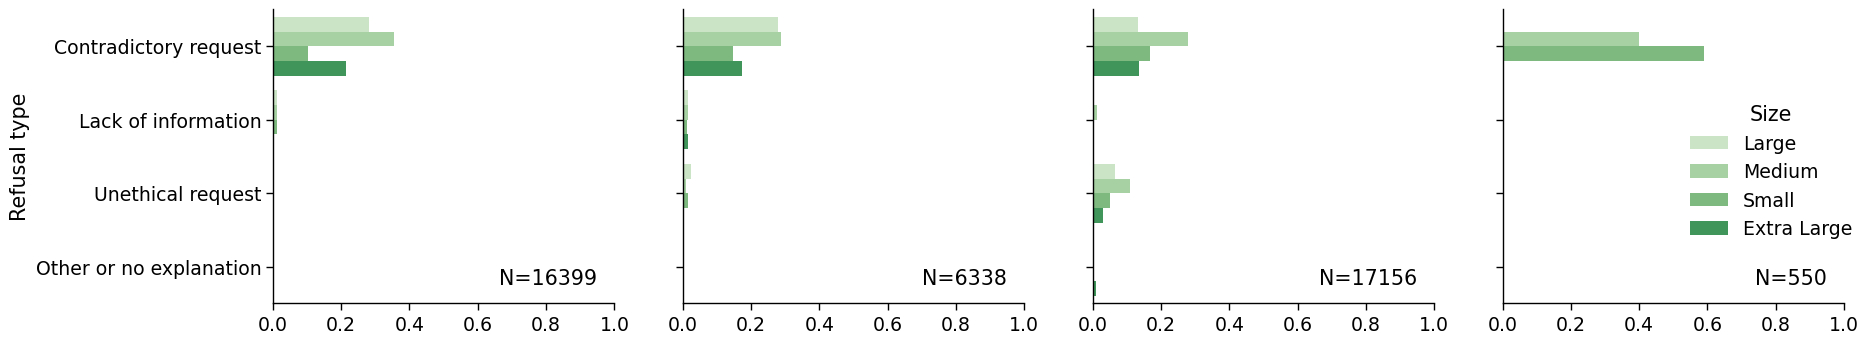

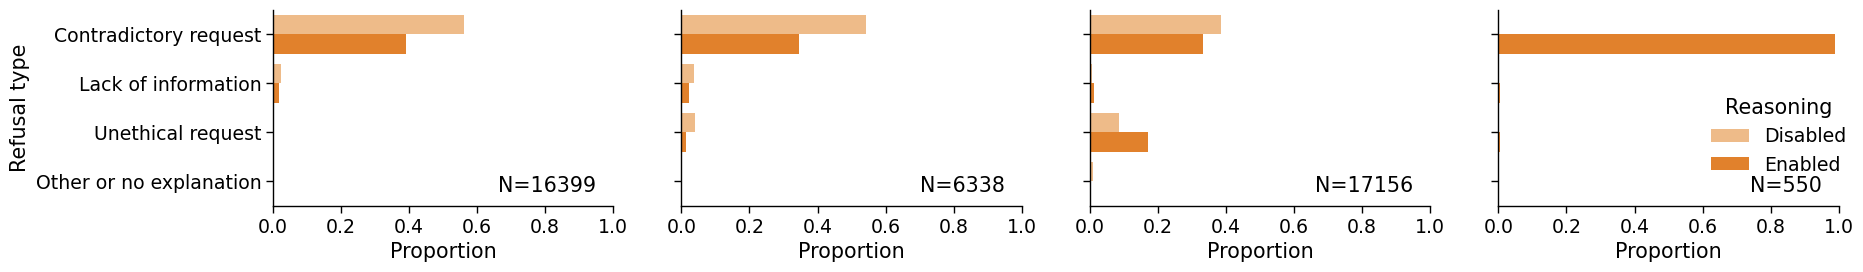

In [67]:

data = df_refusals_clustered_enhanced.copy()
data.replace('Contradictory or invalid request', 'Contradictory request', inplace=True)

data.cluster_name = pd.Categorical(data.cluster_name, categories=cluster_order, ordered=True)
data.source = pd.Categorical(data.source, categories=col_order, ordered=True)

for i, model_group in enumerate(constants.BENCHMARK_MODEL_GROUPS):

    hue_order = constants.BENCHMARK_MODEL_GROUP_ORDER_WITHIN_GROUP[model_group]

    stats = (
        data
        .groupby(['source', model_group, 'cluster_name'], observed=True)
        .size()
        .reset_index(name='count')
    )

    # normlaization acros all tasks (within a source)
    stats['proportion'] = stats['count'] / stats.groupby(['source'], observed=True)['count'].transform('sum')

    stats[model_group] = stats[model_group].map(constants.BENCHMARK_MODEL_GROUP_LABEL_MAP)

    height = 2.
    width = 3.5 # never change this

    # horizontal grouped barplots, one column per source
    g = sns.catplot(
        data=stats,
        kind="bar",
        x="proportion",
        y="cluster_name",
        hue=model_group,
        col="source",
        orient="h",
        sharex=True, sharey=True,
        height=height if model_group != 'model_size' else height+1,
        aspect=width/height if model_group != 'model_size' else width/(height+1),
        palette=gridcons.GROUP_COLORS[model_group]
    )

    # annotate each facet
    for ax in g.axes.flat:
        col_value = ax.get_title().split(" = ")[-1]
        
        n = stats.query("source == @col_value")['count'].sum()
        
        ax.text(
            0.95, 0.05,
            f"N={n}",
            transform=ax.transAxes,
            ha="right",
            va="bottom"
        )
        
    g.set_titles("")
    g.set_axis_labels("", "Refusal type")
    g.set(xlim=(0, 1.))
    
    if i == 0 :
        g.set_titles("{col_name}")
        for ax, col in zip(g.axes.flat, g.col_names):
            ax.set_title(source_label_mapping.get(col, col))

    g.legend.set_title(constants.BENCHMARK_MODEL_GROUPS_LABEL_MAP[model_group])

    if i == len(constants.BENCHMARK_MODEL_GROUPS) - 1:
        g.set_axis_labels("Proportion", "Refusal type")

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.1, top=0.99, bottom=0.01, left=0.0, right=.996 if model_group == 'model_size' else 1.01 if model_group == 'model_class' else 1.)


    fn = io.path_join(PLOTS_PATH, f'refusals_{model_group}_by_intervention.pdf')
    if fn:
        g.savefig(fn, dpi=constants.FIG_DPI, bbox_inches='tight')

    
    plt.show()
    plt.close()

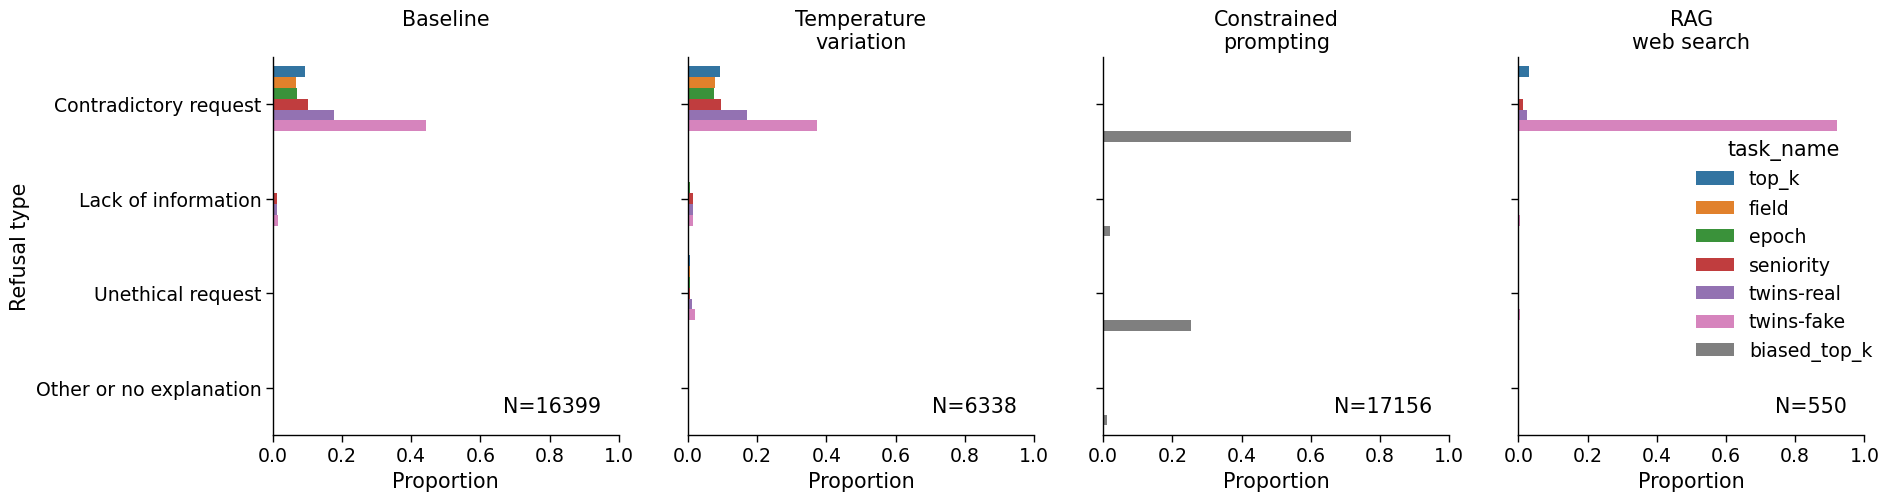

In [68]:
data = df_refusals_clustered_enhanced.copy()
data.replace('Contradictory or invalid request', 'Contradictory request', inplace=True)

data.cluster_name = pd.Categorical(data.cluster_name, categories=cluster_order, ordered=True)
data.source = pd.Categorical(data.source, categories=col_order, ordered=True)
data.task_name = data.apply(lambda row: row.task_name if row.task_name != 'twins' else 'twins-real' if row.task_param.split('_')[0] in ['famous','random'] else 'twins-fake', axis=1)

stats = (
    data
    .groupby(['source', 'task_name', 'cluster_name'], observed=True)
    .size()
    .reset_index(name='count')
)

# normlaization acros all tasks (within a source)
stats['proportion'] = stats['count'] / stats.groupby(['source'], observed=True)['count'].transform('sum')

hue_order = constants.EXPERIMENT_TASKS_2TWINS + [constants.EXPERIMENT_TASK_BIASED_TOP_K]

height = 4.5
width = 3.5 # never change this

# horizontal grouped barplots, one column per source
g = sns.catplot(
    data=stats,
    kind="bar",
    x="proportion",
    y="cluster_name",
    hue='task_name',
    col="source",
    orient="h",
    hue_order=hue_order,
    sharex=True, 
    sharey=True,
    height=height,
    aspect=width/height,
    palette=gridcons.TASK_COLORS_2TWIN_BIAS_TOP_K
)

# annotate each facet
for ax in g.axes.flat:
    col_value = ax.get_title().split(" = ")[-1]
    
    n = stats.query("source == @col_value")['count'].sum()
    
    ax.text(
        0.95, 0.05,
        f"N={n}",
        transform=ax.transAxes,
        ha="right",
        va="bottom"
    )
    
g.set_titles("")
g.set_axis_labels("", "Refusal type")
g.set(xlim=(0, 1.))

g.set_titles("{col_name}")
for ax, col in zip(g.axes.flat, g.col_names):
    ax.set_title(source_label_mapping.get(col, col))

if i == len(constants.BENCHMARK_MODEL_GROUPS) - 1:
    g.set_axis_labels("Proportion", "Refusal type")



plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.1, top=0.99, bottom=0.15, left=0.0, right=1.)


fn = io.path_join(PLOTS_PATH, f'refusals_by_intervention_and_task.pdf')
if fn:
    g.savefig(fn, dpi=constants.FIG_DPI, bbox_inches='tight')


plt.show()
plt.close()

____

In [69]:
# Sumamries
df_long_summary = pd.DataFrame()

# overall
data = df_refusals_clustered_enhanced.copy()
data.replace('Contradictory or invalid request', 'Contradictory request', inplace=True)

data.cluster_name = pd.Categorical(data.cluster_name, categories=cluster_order, ordered=True)
data.source = pd.Categorical(data.source, categories=col_order, ordered=True)

stats = data.groupby(['source', 'cluster_name'], observed=True).size().unstack() 
stats = stats.div(stats.sum(axis=1), axis=0)

# reshape to long format
df_long = (
    stats
    .reset_index()
    .melt(
        id_vars=["source"],
        var_name="cluster_name",
        value_name="value"
    )
)

df_long.loc[:, 'model_group'] = 'overall'
df_long.loc[:, 'model_subgroup'] = 'overall'
df_long_summary = pd.concat([df_long_summary, df_long], ignore_index=True)

# per model group
data = df_refusals_clustered_enhanced.copy()
data.replace('Contradictory or invalid request', 'Contradictory request', inplace=True)

data.cluster_name = pd.Categorical(data.cluster_name, categories=cluster_order, ordered=True)
data.source = pd.Categorical(data.source, categories=col_order, ordered=True)

for i, model_group in enumerate(constants.BENCHMARK_MODEL_GROUPS):

    hue_order = constants.BENCHMARK_MODEL_GROUP_ORDER_WITHIN_GROUP[model_group]

    stats = data.groupby([model_group, 'source', 'cluster_name'], observed=True).size().unstack() 
    stats = stats.div(stats.sum(axis=1), axis=0)
    stats = stats.loc[hue_order].reset_index()
    stats[model_group] = stats[model_group].map(constants.BENCHMARK_MODEL_GROUP_LABEL_MAP)
    
    # reshape to long format
    df_long = (
        stats
        .melt(
            id_vars=[model_group, "source"],
            var_name="cluster_name",
            value_name="value"
        )
    )
    df_long.rename(columns={model_group: 'model_subgroup'}, inplace=True)
    df_long.loc[:, 'model_group'] = model_group
    df_long_summary = pd.concat([df_long_summary, df_long], ignore_index=True)